# Text Classification using Tensorflow 2.0
## Yunita Sari

Kita akan menggunakan dataset berupa tweet mengenai sentiment dari airline. 

In [1]:
import pandas as pd
import nltk
import re
import tensorflow as tf
from nltk.tokenize import WordPunctTokenizer
df = pd.read_csv('Tweets.csv')

## Data exploration
**Latihan**: Tambahan eksplorasi yang lain, misal dengan menggunakan wordcloud atau bar graphic untuk mengetahui frekuensi dari kata yang ada di dalam dataset.

In [2]:
df.head(30)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [3]:
tweets = df["text"].values
labels = df['airline_sentiment'].values
print (tweets[0:5])

['@VirginAmerica What @dhepburn said.'
 "@VirginAmerica plus you've added commercials to the experience... tacky."
 "@VirginAmerica I didn't today... Must mean I need to take another trip!"
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@VirginAmerica and it's a really big bad thing about it"]


## Data Cleaning
**Latihan** : Tambahkan step cleaning yang lain, sehingga data lebih mudah diproses

In [4]:
def clean_tweets(tweet):
    user_removed = re.sub(r'@','',tweet)
    link_removed = re.sub('https?://[A-Za-z0-9./]+','',user_removed)
    number_removed = re.sub('[^a-zA-Z]', ' ', link_removed)
    lower_case_tweet= number_removed.lower()
    tok = WordPunctTokenizer()
    words = tok.tokenize(lower_case_tweet)
    clean_tweet = (' '.join(words)).strip()
    return clean_tweet

In [5]:
cleaned_tweets = []
for tweet in tweets:
    cleaned_tweets.append(clean_tweets(str(tweet)))
print(cleaned_tweets[0:5])

['virginamerica what dhepburn said', 'virginamerica plus you ve added commercials to the experience tacky', 'virginamerica i didn t today must mean i need to take another trip', 'virginamerica it s really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse', 'virginamerica and it s a really big bad thing about it']


## Data Preparation
Pada bagian ini, dimensi data perlu disesuaikan agar sesuai dengan kebutuhan Tensorflow

In [6]:
import numpy as np
len_tweet = []
tok = WordPunctTokenizer()
for tweet in cleaned_tweets:
    len_tweet.append(len(tok.tokenize(tweet)))
print("Panjang maximum twitter:",np.max(len_tweet))


Panjang maximum twitter: 34


### Target diubah ke dalam bentuk numerik

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(set(labels)))
print(list(le.classes_))
num_labels = le.transform(labels) 

['negative', 'neutral', 'positive']


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_tweets, num_labels, test_size=0.2, random_state=42)
print (len(X_train))

11712


In [9]:
print (len(X_test))

2928


In [10]:
print (set(y_train))

{0, 1, 2}


### Target diubah ke dalam bentuk categorical (binary)

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, 3)

In [12]:
y_test = tf.keras.utils.to_categorical(y_test, 3)

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os
import random

### Membuat list vocabulary
list vocab hanya boleh di*generate* dari train data

In [14]:
t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(np.array(X_train))

In [15]:
vocab_size = len(t.word_index) + 1

### Tiap kata/token di*convert* ke dalam bentuk indeks

In [16]:
encoded_X_train = t.texts_to_sequences(X_train)

In [17]:
encoded_X_test = t.texts_to_sequences(X_test)

### Padding, agar panjang input data sama (max length). Padding akan menambahkan indeks bernilai 0, yang bisa diletakkan di depan atau dibelakang sequence

In [18]:
max_length = 33
padded_X_train = tf.keras.preprocessing.sequence.pad_sequences(encoded_X_train, maxlen=max_length, padding='post')
print(padded_X_train)

[[  6   5  39 ...   0   0   0]
 [ 18 198 452 ...   0   0   0]
 [ 18 240   3 ...   0   0   0]
 ...
 [ 16  47   9 ...   0   0   0]
 [  6  34  73 ...   0   0   0]
 [ 18  22  27 ...   0   0   0]]


In [19]:
padded_X_test = tf.keras.preprocessing.sequence.pad_sequences(encoded_X_test, maxlen=max_length, padding='post')
print(padded_X_test)

[[ 16   5 106 ...   0   0   0]
 [ 12  63  14 ...   0   0   0]
 [ 18  49  14 ...   0   0   0]
 ...
 [ 12  13   2 ...   0   0   0]
 [ 16 240  34 ...   0   0   0]
 [ 16  71  71 ...   0   0   0]]


In [20]:
print(padded_X_train.shape,y_train.shape)

(11712, 33) (11712, 3)


In [21]:
print(padded_X_test.shape,y_test.shape)

(2928, 33) (2928, 3)


## Membuat Model NN
Pada model ini, hanya terdiri dari layer embedding, 1 layer LSTM dan softmax layer 

In [22]:
model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))

# Add an RNN layer with 128 internal units.
model.add(layers.SimpleRNN(128))

# Add a Dense layer with 3 units and softmax activation.
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 50)            537550    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               22912     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 560,849
Trainable params: 560,849
Non-trainable params: 0
_________________________________________________________________


## Model di compile

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

### Model di latih pada training data

In [24]:
epochs = 5
batch_size = 64

history = model.fit(padded_X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 10540 samples, validate on 1172 samples
Epoch 1/5
10540/10540 [==============================] - 7s 685us/sample - loss: 0.7956 - accuracy: 0.6664 - val_loss: 0.7248 - val_accuracy: 0.6988
Epoch 2/5
10540/10540 [==============================] - 5s 493us/sample - loss: 0.5984 - accuracy: 0.7632 - val_loss: 0.6542 - val_accuracy: 0.7338
Epoch 3/5
10540/10540 [==============================] - 5s 494us/sample - loss: 0.4660 - accuracy: 0.8198 - val_loss: 0.7755 - val_accuracy: 0.7073
Epoch 4/5
10540/10540 [==============================] - 5s 475us/sample - loss: 0.3563 - accuracy: 0.8676 - val_loss: 0.7713 - val_accuracy: 0.7150
Epoch 5/5
10540/10540 [==============================] - 5s 466us/sample - loss: 0.2609 - accuracy: 0.9054 - val_loss: 0.8361 - val_accuracy: 0.7082


## Model di evaluasi pada test data

In [25]:
accr = model.evaluate(padded_X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2928/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test set
  Loss: 0.710
  Accuracy: 0.749


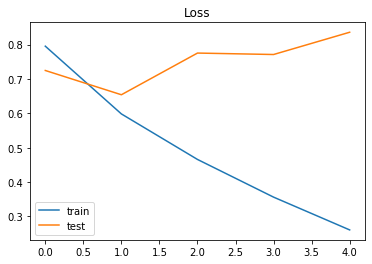

In [26]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


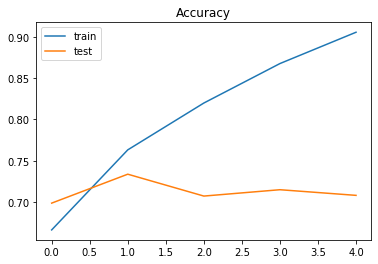

In [28]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [29]:
new_tweet = ['The airlines services really make me sick']
seq = t.texts_to_sequences(new_tweet)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[0.01092732 0.26585573 0.72321695]] 2


In [30]:
print(re.sub('@','',"@elsinet as@dkej @csada"))

elsinet asdkej csada


## LATIHAN
1. Gunakan word2vec atau pre-trained word embedding
2. Tambahkan dropout layer
3. Evaluasi apakah akurasi dari model bisa bertambah?